# Data analysis regular blast wave

In [1]:
import script.pyPLUTO as pp
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from scipy.ndimage import convolve
from scipy.optimize import curve_fit

# some commonly used constants
CONST_mp = 1.67262171e-24  # gr

In [2]:
mpl.rcParams["figure.dpi"] = 150

Usefull functions

In [3]:
def get_extent(file, firstline):
    """this functions retrieves the extent of the grid (in code-units) and number of points from the grid.out 
    file in one dimension (starting at firstline)
    
    file: the grid.out file
    firstline: the line in the file to look for the number of points in that dimension"""
    with open(file, "r") as gridfile:
        lines = gridfile.readlines()
        # get the number of points
        NUM_POINTS = int(lines[firstline])

        # get the extent of the x-axis (in code units)
        # the first line of the grid, so minimum coordinate
        line = lines[firstline+1]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_min = float(parts[1])
        # the last line
        line = lines[firstline+NUM_POINTS]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_max = float(parts[2])
    
    return (NUM_POINTS, (d_min, d_max))

Import metadata about the output such as the time corresponding to each files and conversion factors from code units to physical units

In [4]:
# specify the directories where the data is stored and where the output should be stored
DATA_DIR = "data/"
OUT_DIR = "images/"

# get info about the stored data
file_data = pd.read_csv(DATA_DIR+"dbl.out", sep=" ", names=["index", "t", "dt", "step", "type", "little", "rho",
                                                            "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"])
# delete columns that are not needed
for column in ["index", "type", "little", "rho", "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"]:
    del file_data[column]

# define the conversion factors
UNIT_DENSITY = 1*CONST_mp
UNIT_LENGTH = 1.49597892e13 # cm (1AU)
UNIT_VELOCITY = 1e5 # cm/s
UNIT_TIME = UNIT_LENGTH/UNIT_VELOCITY

X_POINTS = 0
Y_POINTS = 0
X_EXTENT = (0,0)
Y_EXTENT = (0,0)

# get the extend of the grid
# get the extent of the x-axis (in code units)
X_POINTS, X_EXTENT = get_extent(DATA_DIR+"grid.out", 9)
# get the extent of the y-axis
Y_POINTS, Y_EXTENT = get_extent(DATA_DIR+"grid.out", 10+X_POINTS)

# number of files saved
N = len(file_data["t"])

## calculate the wave speed

Reading Data file : data/data.0020.dbl


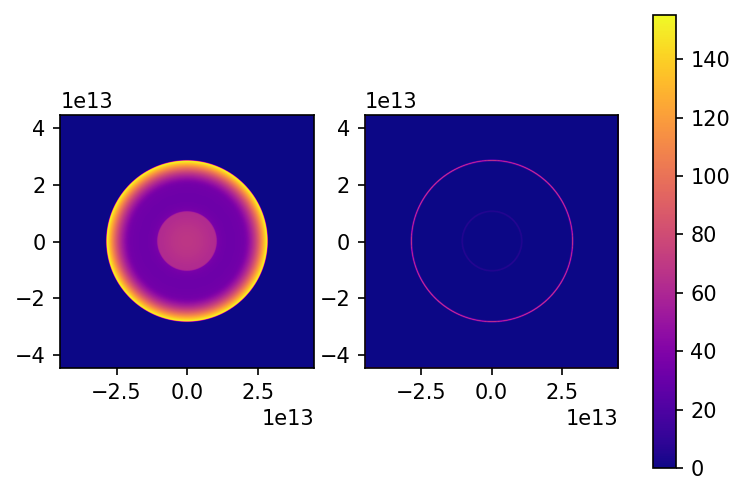

In [40]:
D = pp.pload(20, w_dir=DATA_DIR)
rho = D.rho
prs = D.prs

extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH for value in extent_temp]

# kernel for edge detection
K3 = np.array([[-1,-1,-1],
              [-1,8,-1],
              [-1,-1,-1]])
Ka = 1/10*np.array([[1,1,1],
              [1,2,1],
              [1,1,1]])
edges = convolve(prs, K3, mode="constant", cval=80)
edges = convolve(np.abs(edges), Ka, mode="constant", cval=80)


fig, ax = plt.subplots(1,2)

#im=ax.imshow(np.log(plotvar[i]), vmin=np.log(MIN), vmax=np.log(MAX), cmap="plasma")
im=ax[0].imshow(prs, cmap="plasma", extent=extent)

#im=ax.imshow(np.log(plotvar[i]), vmin=np.log(MIN), vmax=np.log(MAX), cmap="plasma")
im=ax[1].imshow(np.abs(edges), cmap="plasma", extent=extent)

fig.colorbar(im, ax=ax)

### calculate wave speed along diagonal

Test voor vinden van edge wave in een bepaalde richting

In [6]:
mid_point = np.array([(X_POINTS-1)/2, (Y_POINTS-1)/2])
direction = np.array([np.sqrt(2)/2, np.sqrt(2/2)])

point = mid_point + direction
step = 1
max_val = 0
max_step = 0

while np.max(point) < X_POINTS and np.min(point) > 0:
    coord = np.round(point)
    val = np.abs(edges)[int(coord[0]), int(coord[0])]
    if val > max_val:
        max_val = val
        max_step = step
    point += direction
    step += 1
    coord = np.round(point)

In [8]:
def line(x, a, b):
    return a*x+b

snelheid: 13.021303 km/s


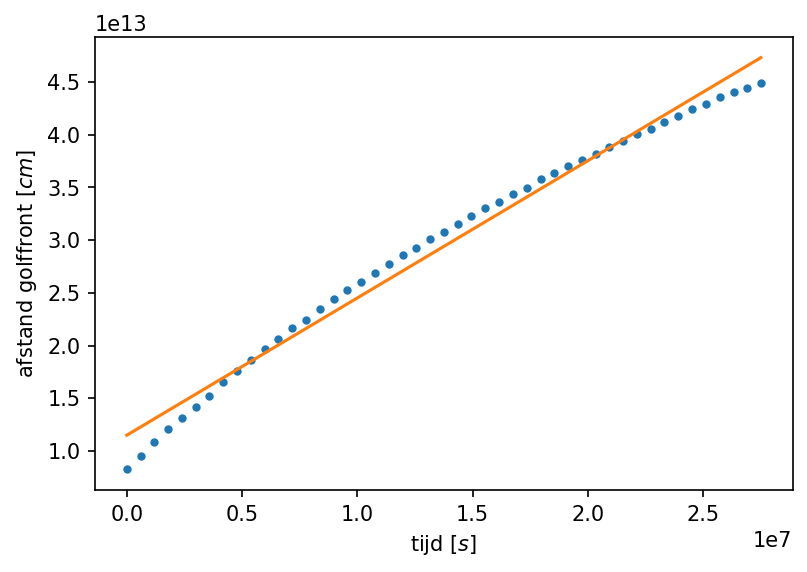

In [9]:
fig, ax = plt.subplots(1,1)

T = file_data["t"].values*UNIT_TIME
Y = np.array(step_array)*(X_EXTENT[1]-X_EXTENT[0])/X_POINTS*UNIT_LENGTH

T = T[0:47]
Y = Y[0:47]

param, covar = curve_fit(line, T, Y, (1e6, 1e13))

ax.set_ylabel("afstand golffront $[cm]$")
ax.set_xlabel("tijd $[s]$")

ax.plot(T, Y, '.')
ax.plot(T, line(T, *param))

print("snelheid: %f km/s" %(param[0]/(1e5)))

In [57]:
D = pp.pload(5, w_dir=DATA_DIR)
D.prs-8

Reading Data file : data/data.0005.dbl


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
mid_point = np.array([(X_POINTS-1)/2, (Y_POINTS-1)/2])
theta_array = np.linspace(0,2*np.pi,60,endpoint=False)
directions = {theta : np.array([np.cos(theta), np.sin(theta)]) for theta in theta_array}

step_arrays = {theta : [] for theta in theta_array}

for i in range(15):
    D = pp.pload(i, w_dir=DATA_DIR+"/")
    prs = D.prs-8   # subtract background pressure
    # find the edge of the wave
    edges = convolve(prs, K3, mode="constant", cval=8)
    edges = convolve(np.abs(edges), Ka, mode="constant", cval=8)
    
    # calculate for every direction the wave position
    for theta in theta_array:
        direction = directions[theta]
        step_array = step_arrays[theta]
        point = mid_point + direction
        step = 1
        max_val = 0
        max_step = 0

        while np.max(point) < X_POINTS-10 and np.min(point) > 9:
            coord = np.round(point)
            val = edges[int(coord[0]), int(coord[0])]
            if val > max_val:  # multiply by step (distance to origin) to adjust for the dissipation of the wave
                max_val = val
                max_step = step
            point += direction
            step += 1
            coord = np.round(point)
        step_array.append(max_step)

Reading Data file : data//data.0000.dbl
Reading Data file : data//data.0001.dbl
Reading Data file : data//data.0002.dbl
Reading Data file : data//data.0003.dbl
Reading Data file : data//data.0004.dbl
Reading Data file : data//data.0005.dbl
Reading Data file : data//data.0006.dbl
Reading Data file : data//data.0007.dbl
Reading Data file : data//data.0008.dbl
Reading Data file : data//data.0009.dbl
Reading Data file : data//data.0010.dbl
Reading Data file : data//data.0011.dbl
Reading Data file : data//data.0012.dbl
Reading Data file : data//data.0013.dbl
Reading Data file : data//data.0014.dbl


In [68]:
params = {theta : 0}

for theta in theta_array:
    T = file_data["t"].values*UNIT_TIME
    T = T[:15]
    Y = np.array(step_arrays[theta])*(X_EXTENT[1]-X_EXTENT[0])/X_POINTS*UNIT_LENGTH
    Y = Y[:15]
    
    param, covar = curve_fit(line, T, Y, (1e6, 1e13))
    
    params[theta] = param

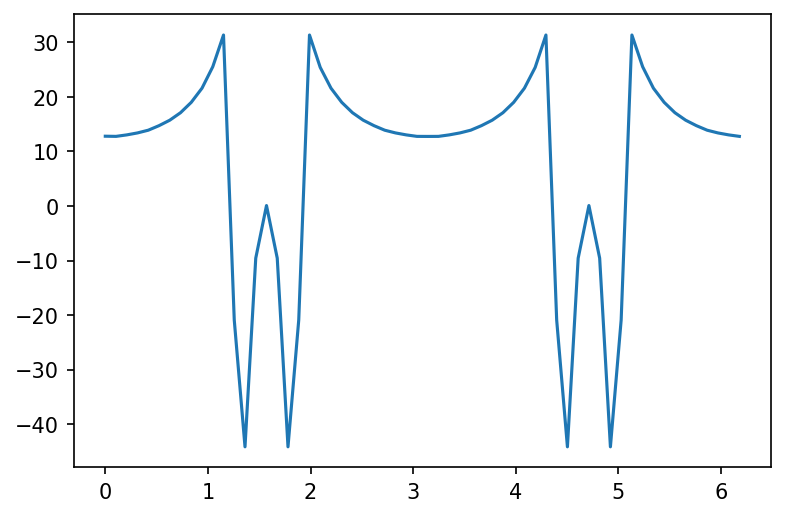

In [69]:
fig, ax = plt.subplots(1,1)

speeds = [params[theta][0]/(1e5) for theta in theta_array]

ax.plot(theta_array, speeds)

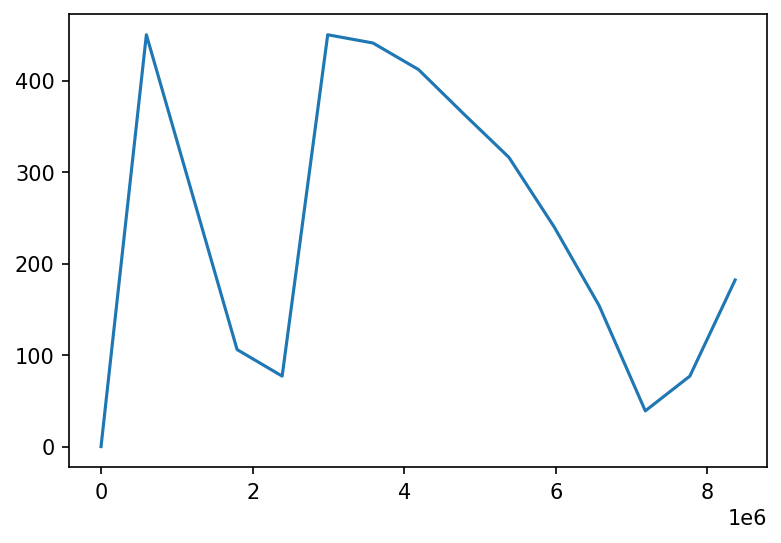

In [73]:
fig, ax = plt.subplots(1, 1)

t = theta_array[16]
T = file_data["t"].values*UNIT_TIME
T = T[:15]
ax.plot(T, step_arrays[t])

## make plots of pressure

In [13]:
rho = []
vx = []
vy = []
prs = []

for i in range(N):
    D = pp.pload(i, w_dir=FOLDER+"/")
    rho.append(D.rho)
    vx.append(D.vx1)
    vy.append(D.vx2)
    prs.append(D.prs)

NameError: name 'FOLDER' is not defined

In [ ]:
MAX = 0
MIN = 10

plotvar = prs

for i in range(10):
    m = np.min(plotvar[i])
    M = np.max(plotvar[i])
    if (m<MIN):
        MIN=m
    if M>MAX:
        MAX=M

In [ ]:
for i in range(N):
    fig, ax = plt.subplots(1,1)
    
    #im=ax.imshow(np.log(plotvar[i]), vmin=np.log(MIN), vmax=np.log(MAX), cmap="plasma")
    im=ax.imshow(plotvar[i], vmin=MIN, vmax=MAX, cmap="plasma")

    fig.colorbar(im, ax=ax)

    plt.title("time: %.4f s"%(i*0.0005))
    
    fig.savefig("images/prs-linear%04i.png"%i)
    
    plt.close(fig=fig)
    
    if i%10 == 0:
        print(i)